In [109]:
library(tidyverse)
library(ggplot2)
library(dplyr)
library(scales)
library(lubridate)
library(cowplot)
library(binom)
library(stats)
library(emdbook)
library(ramify)
library(gridExtra)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




# 1)

## 1.1)

In [16]:
n_succ = 7
n_trial = 20
p = seq(0,1, by= 0.01)

#Priors
priorU = function(p){g<-dunif(p, 0, 1)
                     return (g)}

priorJ = function(p){g<-dbeta(p,0.5, 0.5)
                     return (g)}
priorC = function(p){
    g <- ifelse(p <= 0.2, p,
              ifelse(p > 0.2 & p <= 0.3, 0.2,
                    ifelse(p>0.3 & p <= 0.5, 0.5-p,0))) 
    return (g)
}



#likelihood
lhB = function(p){g <-dbinom(n_succ, n_trial, p)*choose(n_trial, n_succ)
                 return (g)}



#normalisation terms
normU = integrate(function(x){lhB(x)*priorU(x)}, lower=0, upper=1)$value
normJ = integrate(function(x){lhB(x)*priorJ(x)}, lower=0, upper=1)$value
normC = integrate(function(x){lhB(x)*priorC(x)}, lower=0, upper=1)$value



#posterior
postU = function(p){i <- lhB(p)*priorU(p)/normU
                   return (i)}
postJ = function(p){i <- lhB(p)*priorJ(p)/normJ
                   return (i)}
postC = function(p){i <- lhB(p)*priorC(p)/normC
                   return (i)}
pU = postU(p)
pJ = postJ(p)
pC = postC(p)

pU[is.nan(pU)] = 0
pJ[is.nan(pJ)] = 0
pC[is.nan(pC)] = 0

## 1.2)

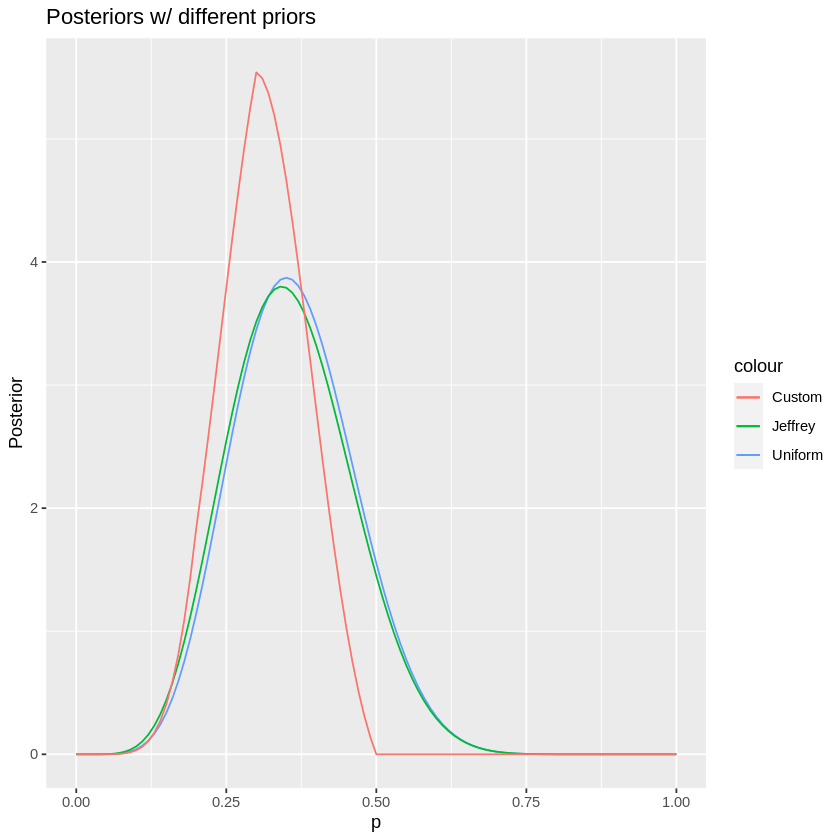

In [18]:
ggplot(data=data.frame(p, pU, pJ, pC), aes(x=p))+geom_line(aes(y=pU, color='Uniform'))+
                                                geom_line(aes(y=pJ, color='Jeffrey'))+
                                                geom_line(aes(y=pC, color='Custom'))+
                                                labs(title='Posteriors w/ different priors',
                                                      x='p',
                                                      y='Posterior')

In [19]:
# Summary of results
moment1U = integrate(function(x){x*postU(x)}, lower=0, upper=1)$value 
moment1J = integrate(function(x){x*postJ(x)}, lower=0, upper=1)$value 
moment1C = integrate(function(x){x*postC(x)}, lower=0, upper=1)$value 

moment2U = integrate(function(x){(moment1U - x)*(moment1U - x)*postU(x)}, lower=0, upper=1)$value 
moment2J = integrate(function(x){(moment1J - x)*(moment1J - x)*postJ(x)}, lower=0, upper=1)$value
moment2C = integrate(function(x){(moment1C - x)*(moment1C - x)*postC(x)}, lower=0, upper=1)$value

cat('The first and second moment using a uniform prior is: \t', moment1U, ' , ', moment2U, '\n')
cat('The first and second moment using a Jeffrey prior is: \t', moment1J, ' , ', moment2J, '\n')
cat('The first and second moment using a custom prior is: \t', moment1C, ' , ', moment2C, '\n')

The first and second moment using a uniform prior is: 	 0.3636364  ,  0.01006109 
The first and second moment using a Jeffrey prior is: 	 0.3571429  ,  0.01043599 
The first and second moment using a custom prior is: 	 0.3120452  ,  0.004998428 


## 1.3)

In [30]:
# Credibility interval
xU = ncredint(pvec=p, npost=pU, level=0.95, tol=0.01, verbose=FALSE)
xJ = ncredint(pvec=p, npost=pJ, level=0.95, tol=0.01, verbose=FALSE)
xC = ncredint(pvec=p, npost=pC, level=0.95, tol=0.01, verbose=FALSE)


uniform = c(moment1U, moment2U, xU[['lower']], xU[['upper']])
jeffrey = c(moment1J, moment2J, xJ[['lower']], xJ[['upper']])
custom = c(moment1C, moment2C, xC[['lower']], xC[['upper']])



df = data.frame(Uniform = uniform, Jeffrey = jeffrey, Custom=custom,
          row.names=c('First moment', 'Second moment', 'Lower limit (95% credibility)', 'Upper limit (95% credibility)'))
df

,Uniform,Jeffrey,Custom
,<dbl>,<dbl>,<dbl>
First moment,0.36363636,0.35714286,0.312045223
Second moment,0.01006109,0.01043599,0.004998428
Lower limit (95% credibility),0.18000000,0.17000000,0.180000000
Upper limit (95% credibility),0.56000000,0.55000000,0.440000000


## 1.4)

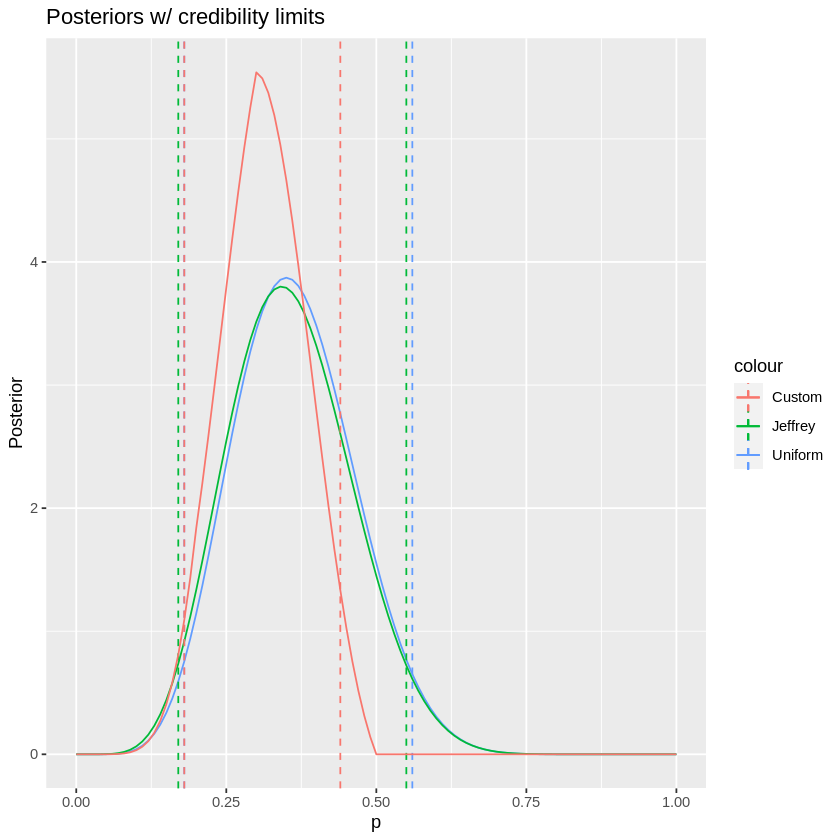

In [38]:
ggplot(data=data.frame(p, pU, pJ, pC), aes(x=p))+
geom_line(aes(y=pU, color='Uniform'))+
geom_vline(aes(xintercept = xU[['lower']], color='Uniform'), linetype='dashed')+
geom_vline(aes(xintercept = xU[['upper']], color='Uniform'), linetype='dashed')+
geom_line(aes(y=pJ, color='Jeffrey'))+
geom_vline(aes(xintercept = xJ[['lower']], color='Jeffrey'), linetype='dashed')+
geom_vline(aes(xintercept = xJ[['upper']], color='Jeffrey'), linetype='dashed')+
geom_line(aes(y=pC, color='Custom'))+
geom_vline(aes(xintercept = xC[['lower']], color='Custom'), linetype='dashed')+
geom_vline(aes(xintercept = xC[['upper']], color='Custom'), linetype='dashed')+
labs(title='Posteriors w/ credibility limits', x='p', y='Posterior')     

# 2)

## 2.1 - 2.2)

Prior,First_moment,Second_moment
<chr>,<dbl>,<dbl>
Uniform,0.1525424,0.001086329
"Beta(1,4)",0.1487603,0.001037957


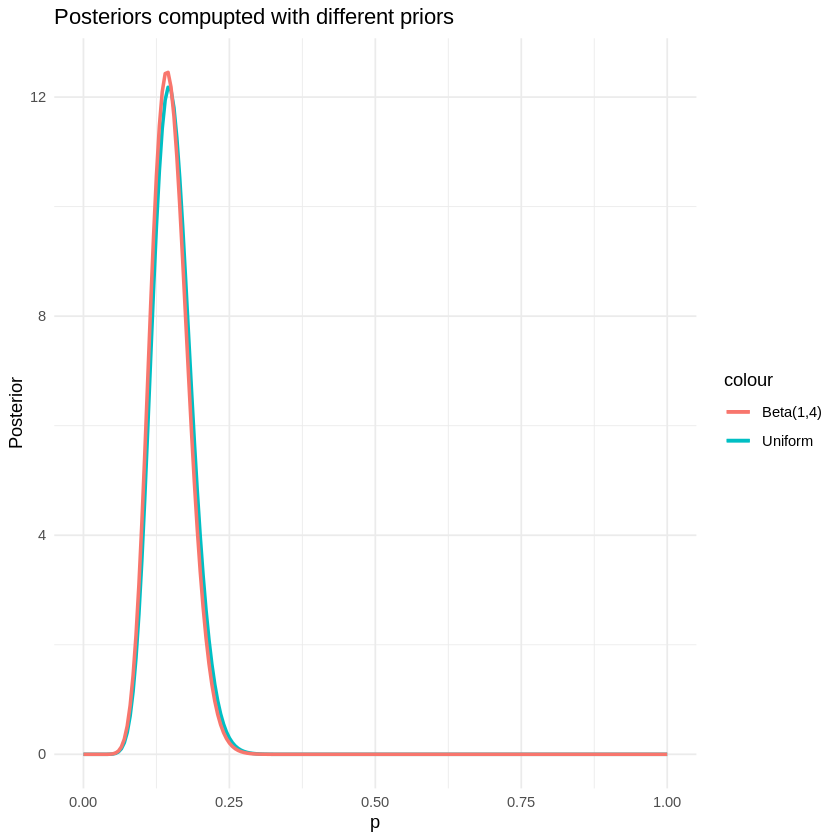

In [97]:
n_succ = 17
n_trial = 116
p = seq(0,1, by= 0.005)

#priors
priorU = function(p){g<-dunif(p, 0, 1)
                     return (g)}

priorC = function(p){g<-dbeta(p,1, 4)
                     return (g)}

#likelihood
lhB = function(p){g <-dbinom(n_succ, n_trial, p)*choose(n_trial, n_succ)
                 return (g)}

#normalisation terms
normU = integrate(function(x){lhB(x)*priorU(x)}, lower=0, upper=1)$value
normC = integrate(function(x){lhB(x)*priorC(x)}, lower=0, upper=1)$value


#posterior
postU = function(p){i <- lhB(p)*priorU(p)/normU
                   return (i)}
postC = function(p){i <- lhB(p)*priorC(p)/normC
                   return (i)}

pU = postU(p)
pC = postC(p)

pU[is.nan(pU)] = 0
pC[is.nan(pC)] = 0

ggplot(data=data.frame(p, pU, pC), aes(x=p))+geom_line(aes(y=pU, color='Uniform'), size=1)+
                                geom_line(aes(y=pC, color='Beta(1,4)'), size=1)+
                                labs(title='Posteriors compupted with different priors',
                                     x='p',
                                     y='Posterior')+
theme_minimal()

moment1U = integrate(function(x){x*postU(x)}, lower=0, upper=1)$value 
moment1C = integrate(function(x){x*postC(x)}, lower=0, upper=1)$value 

moment2U = integrate(function(x){(x-moment1U)*(x-moment1U)*postU(x)}, lower=0, upper=1)$value 
moment2C = integrate(function(x){(x-moment1C)*(x-moment1C)*postC(x)}, lower=0, upper=1)$value

moments <- tibble(
            Prior = c('Uniform', 'Beta(1,4)'),
            First_moment = c(moment1U, moment1C),
            Second_moment = c(moment2U, moment2C)
            )
moments

## 2.3)

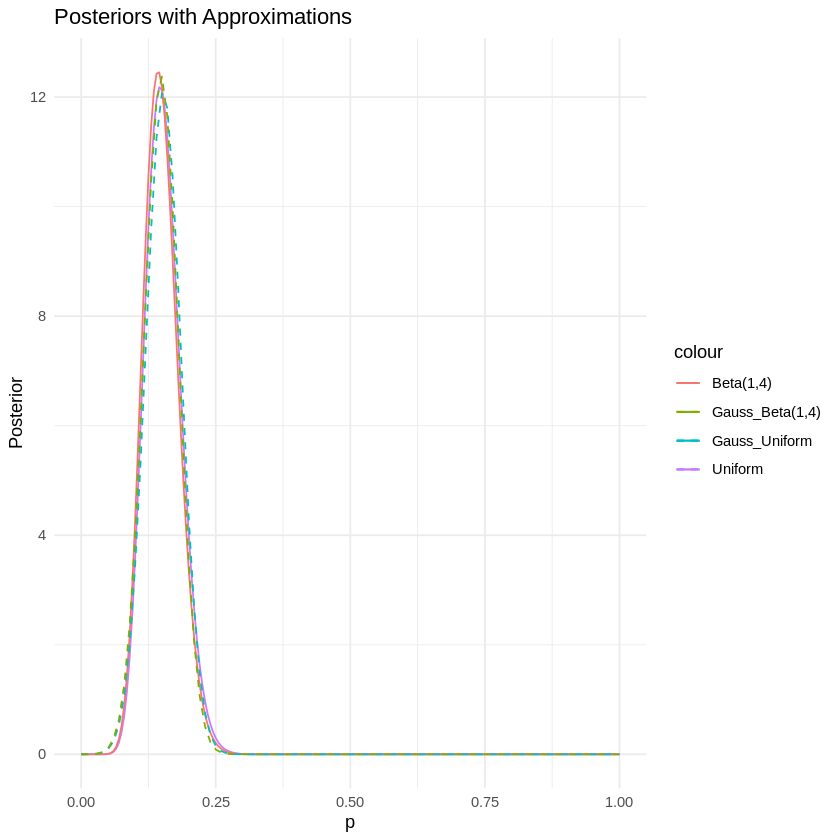

In [98]:

ggplot(data=data.frame(p, pU, pC), aes(x=p))+geom_line(aes(y=pU, color='Uniform'))+
                                geom_line(aes(y=pC, color='Beta(1,4)'))+
                                labs(title='Posteriors with Approximations',
                                     x='p',
                                     y='Posterior')+                               
    geom_function(fun = dnorm, args = list(mean = moment1U, sd = sqrt(moment2U)), aes(color = "Gauss_Uniform"), linetype='dashed')+
    geom_function(fun = dnorm, args = list(mean = moment1C, sd = sqrt(moment2C)), aes(color = "Gauss_Beta(1,4)"), linetype='dashed')+
    theme_minimal()

## 2.4)

In [102]:
xU = ncredint(pvec=p, npost=pU, level=0.95, tol=0.01, verbose=FALSE)
xC = ncredint(pvec=p, npost=pC, level=0.95, tol=0.01, verbose=FALSE)

xnU = ncredint(pvec=p, npost=dnorm(p, mean=moment1U, sd=sqrt(moment2U)),level=0.95,tol=0.01,verbose=FALSE)
xnC = ncredint(pvec=p, npost=dnorm(p, mean=moment1C, sd=sqrt(moment2C)),level=0.95,tol=0.01,verbose=FALSE)


uniform = c(moment1U, moment2U, xU[['lower']], xU[['upper']])
custom = c(moment1C, moment2C, xC[['lower']], xC[['upper']])

gausU = c(moment1U, moment2U, xnU[['lower']], xnU[['upper']])
gausC = c(moment1C, moment2C, xnC[['lower']], xnC[['upper']])


df = data.frame(Uniform = uniform, Gauss_Uniform=gausU, Beta=custom, Gauss_Beta=gausC,
          row.names=c('First moment', 'Second moment', 'Lower limit (95% credibility)', 'Upper limit (95% credibility)'))
df

,Uniform,Gauss_Uniform,Beta,Gauss_Beta
,<dbl>,<dbl>,<dbl>,<dbl>
First moment,0.152542373,0.152542373,0.148760331,0.148760331
Second moment,0.001086329,0.001086329,0.001037957,0.001037957
Lower limit (95% credibility),0.090000000,0.090000000,0.090000000,0.090000000
Upper limit (95% credibility),0.215000000,0.215000000,0.210000000,0.210000000


## 2.5)

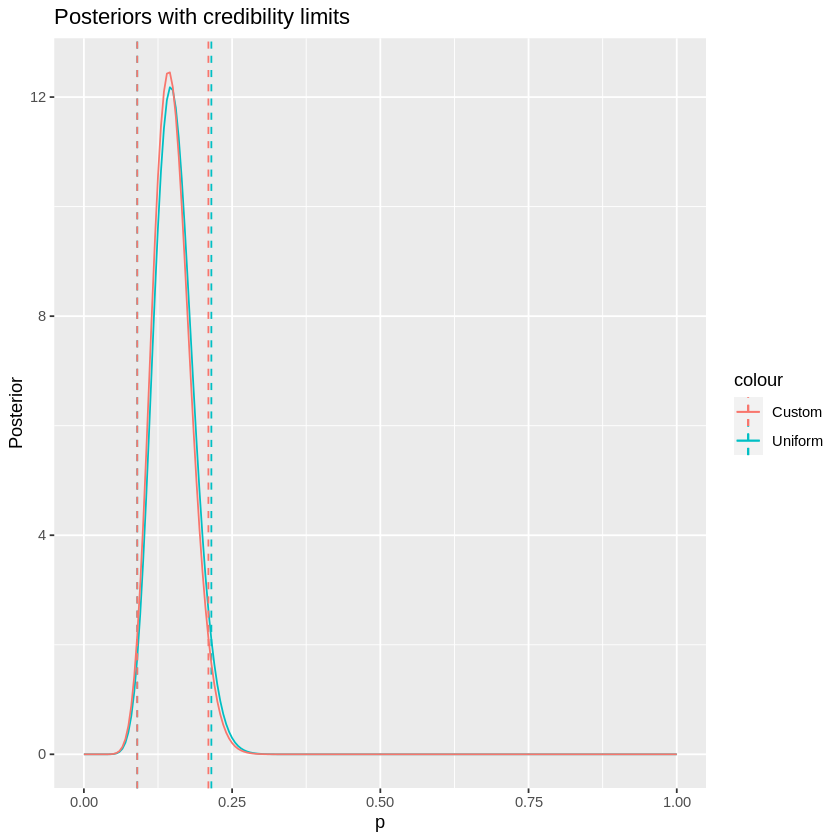

In [104]:
pnU = dnorm(p, mean=moment1U, sd=sqrt(moment2U))
pnC = dnorm(p, mean=moment1C, sd=sqrt(moment2C))
     
ggplot(data=data.frame(p, pU, pnU, pC, pnC), aes(x=p))+geom_line(aes(y=pU, color='Uniform'))+
geom_vline(aes(xintercept = xU[['lower']], color='Uniform'),linetype='dashed')+
geom_vline(aes(xintercept = xU[['upper']], color='Uniform'),linetype='dashed')+
geom_line(aes(y=pC, color='Custom'))+
geom_vline(aes(xintercept = xC[['lower']], color='Custom'),linetype='dashed')+
geom_vline(aes(xintercept = xC[['upper']], color='Custom'),linetype='dashed')+
labs(title='Posteriors with credibility limits', x='p', y='Posterior')   

# 3)

## 3.1)

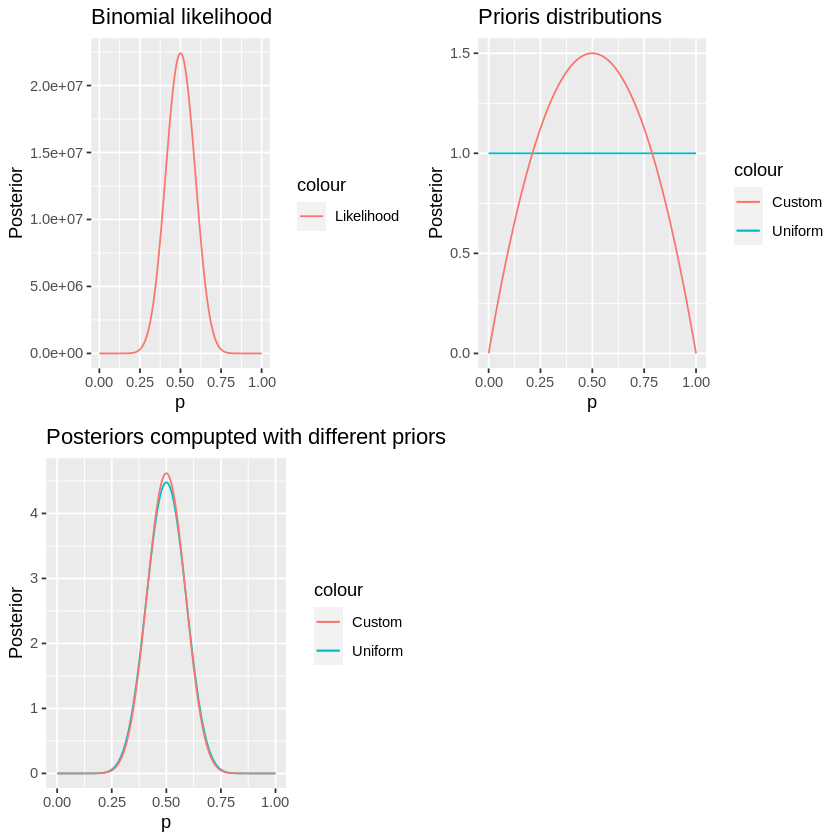

In [118]:
n_trial = 30
n_succ = 15
p = seq(0,1, by= 0.00005)
#priors
priorU = function(p){g<-dunif(p, 0, 1)
                     return (g)}
priorC = function(p){g<-dbeta(p,2, 2)
                     return (g)}

#likelihood
lhB = function(p){g <-dbinom(n_succ, n_trial, p)*choose(n_trial, n_succ)
                 return (g)}

#normalisation terms
normU = integrate(function(x){lhB(x)*priorU(x)}, lower=0, upper=1)$value
normC = integrate(function(x){lhB(x)*priorC(x)}, lower=0, upper=1)$value


#posterior
postU = function(p){i <- lhB(p)*priorU(p)/normU
                   return (i)}
postC = function(p){i <- lhB(p)*priorC(p)/normC
                   return (i)}


prU = priorU(p)
prC = priorC(p)

lh = lhB(p)

pU = postU(p)
pC = postC(p)



pU[is.nan(pU)] = 0
pC[is.nan(pC)] = 0

prior_plot <- ggplot(data=data.frame(p, lh), aes(x=p))+
geom_line(aes(y=lh, color='Likelihood'))+
labs(title='Binomial likelihood',x='p',y='Posterior')


likelihood_plot <- ggplot(data=data.frame(p, prU, prC), aes(x=p))+
geom_line(aes(y=prU, color='Uniform'))+
geom_line(aes(y=prC, color='Custom'))+
labs(title='Prioris distributions',x='p',y='Posterior')

posterior_plot <- ggplot(data=data.frame(p, pU, pC), aes(x=p))+
geom_line(aes(y=pU, color='Uniform'))+
geom_line(aes(y=pC, color='Custom'))+
labs(title='Posteriors compupted with different priors',x='p',y='Posterior')

grid_plot <- grid.arrange(prior_plot, likelihood_plot, posterior_plot, nrow=2, ncol=2)


## 3.2)

In [122]:
mpvU = which.max(pU)
mpvC = which.max(pC)
cat('The most probable value using a uniform prior is:', p[mpvU], '\n')
cat('The most probable value using a beta prior is:', p[mpvC], '\n\n')

xU = ncredint(pvec=p, npost=pU, level=0.95, tol=0.01, verbose=FALSE)
xC = ncredint(pvec=p, npost=pC, level=0.95, tol=0.01, verbose=FALSE)

cat('Uniform 95% credibility interval:', xU,'\n')
cat('Beta 95% credibility interval:', xC)

The most probable value using a uniform prior is: 0.5 
The most probable value using a beta prior is: 0.5 

Uniform 95% credibility interval: 0.33065 0.66935 
Beta 95% credibility interval: 0.3356 0.6644